In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Methods considering:

Downsampling, Helper Function to create metadata(updating)

1. Classifier. 2. Anomoly detection (unspuervised)

## Import Libs


In [ ]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
%matplotlib inline
pd.set_option('display.max_columns', None)

import re 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import joblib
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from imblearn.combine import SMOTETomek
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv('/content/target_dataset.csv')

# EDA

In [ ]:
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


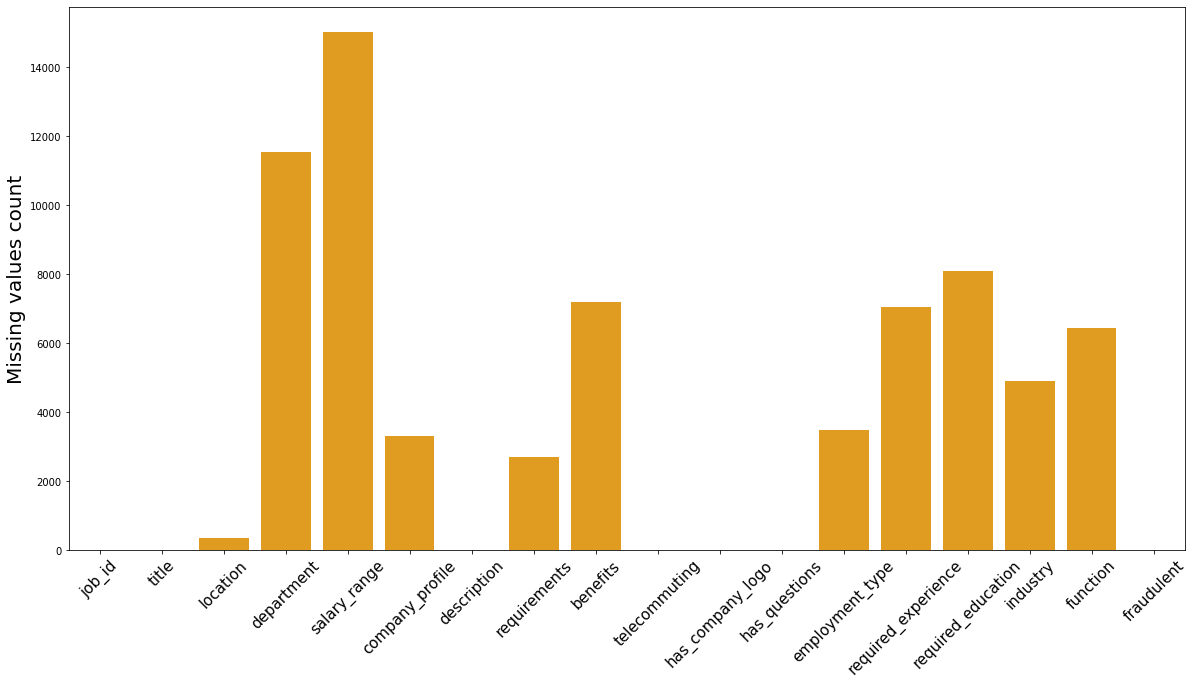

In [ ]:
#check null. Most salary ranges contain null values. As most companies may only reveal it in the packages.
null_values = data.isnull().sum()
plt.figure(figsize = (20,10))
sns.barplot(null_values.index, null_values, color = 'orange')
# plt.suptitle('Missing values in the dataset', size = 20)
plt.ylabel('Missing values count', size = 20)
plt.xticks(rotation = '45', fontsize=15)
plt.show()

In [ ]:
#Check unique values
categorical_columns = []
for col in data.columns:
    print(f'Unique observations in {col}:', data[col].nunique())
    if data[col].nunique() < 14:
        categorical_columns.append(col)
print('Categorical columns:',categorical_columns)

Unique observations in job_id: 17880
Unique observations in title: 11231
Unique observations in location: 3105
Unique observations in department: 1337
Unique observations in salary_range: 874
Unique observations in company_profile: 1709
Unique observations in description: 14801
Unique observations in requirements: 11968
Unique observations in benefits: 6205
Unique observations in telecommuting: 2
Unique observations in has_company_logo: 2
Unique observations in has_questions: 2
Unique observations in employment_type: 5
Unique observations in required_experience: 7
Unique observations in required_education: 13
Unique observations in industry: 131
Unique observations in function: 37
Unique observations in fraudulent: 2
Categorical columns: ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'fraudulent']


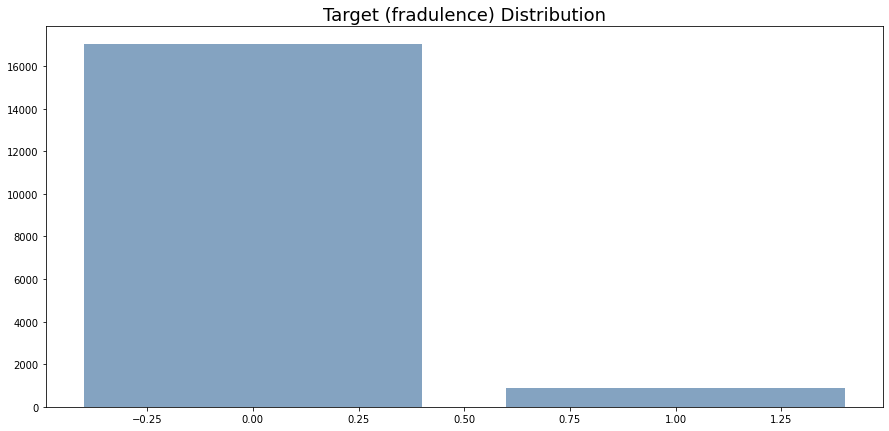

In [ ]:
#Check target value
figure = plt.figure(figsize = (15,7))
target_dist = data['fraudulent'].value_counts()
plt.bar(target_dist.index, target_dist, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Target (fradulence) Distribution', size = 18)
plt.show()

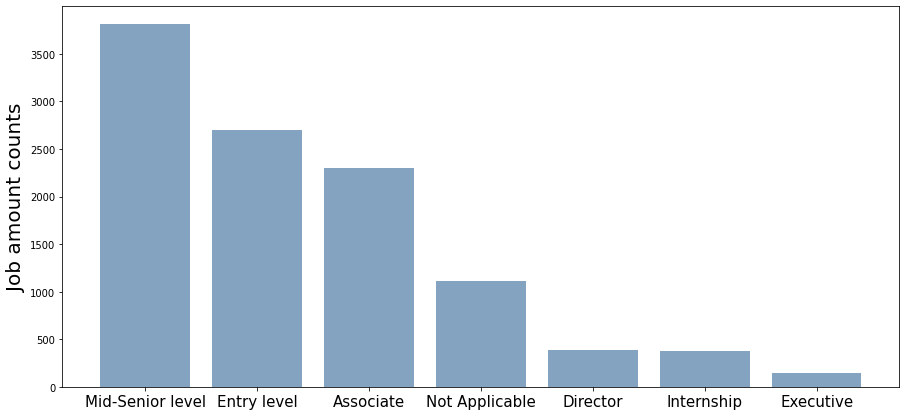

In [ ]:
#Check required experience and related job posts amounts
experience = dict(data.required_experience.value_counts())
figure = plt.figure(figsize = (15,7))
plt.bar(experience.keys(), experience.values(),color=(0.2, 0.4, 0.6, 0.6))
# plt.title('Number of job postings in different required experience', size=20)
# plt.xlabel('Previous experience', size=10)
plt.ylabel('Job amount counts', size=20)
plt.xticks(size=15)
plt.show()

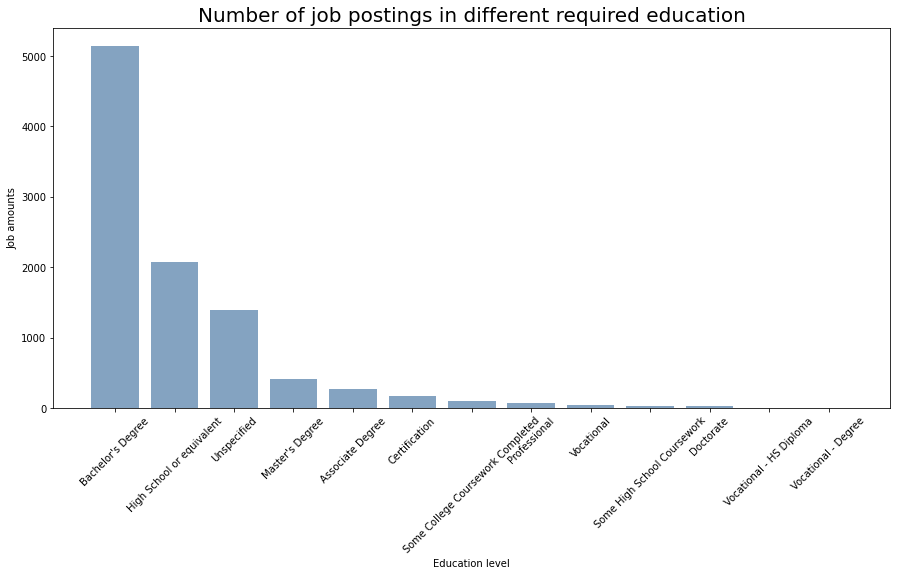

In [ ]:
#Check required education and related job posts amounts
experience = dict(data.required_education.value_counts())
figure = plt.figure(figsize = (15,7))
plt.bar(experience.keys(), experience.values(),color=(0.2, 0.4, 0.6, 0.6))
plt.title('Number of job postings in different required education', size=20)
plt.xlabel('Education level', size=10)
plt.ylabel('Job amounts', size=10)
plt.xticks(rotation=45)
plt.show()

In [ ]:
#fill NA values with empty strings
data.location.fillna(' ', inplace=True)

Text(0, 0.5, 'Job amounts')

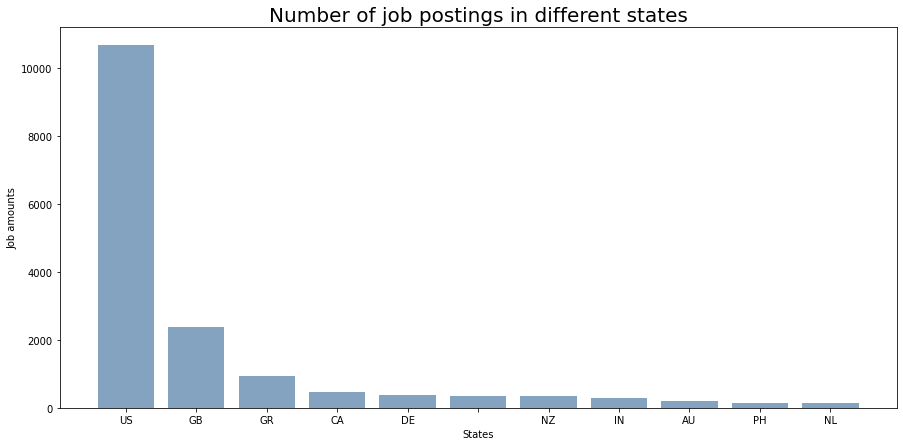

In [ ]:
#check job post in different states

#helper function to split the string and locate the state values
def split(location):
    l = location.split(',')
    return l[0]

state = dict(data.location.apply(split).value_counts()[:11])
plt.figure(figsize=(15,7))
plt.title('Number of job postings in different states', size=20)
plt.bar(state.keys(), state.values(), color=(0.2, 0.4, 0.6, 0.6))
plt.xlabel('States', size=10)
plt.ylabel('Job amounts', size=10)

We will check the most frequent words in the fradulent job posts

In [ ]:
data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']

data.text.fillna(' ', inplace=True)

fraudjobs_text = data[data.fraudulent==0].text

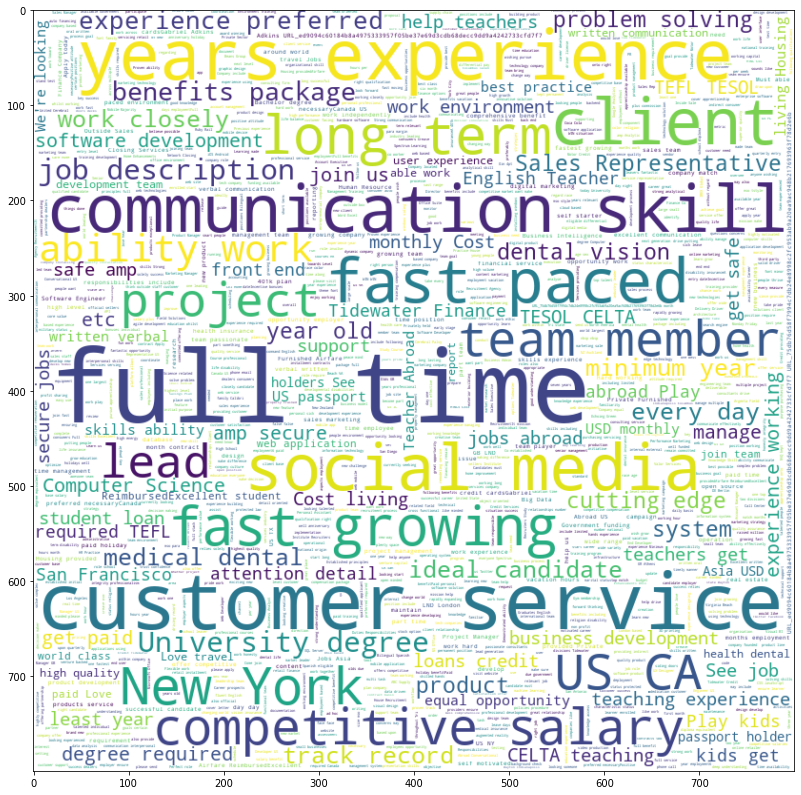

In [ ]:
plt.figure(figsize = (16,14))
wc = WordCloud(background_color='white', min_font_size = 3,  max_words = 3000 , width = 800 , height = 800 , stopwords = stop_words).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

# Data Preprocessing

## modify current features and texts

In [ ]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']

#drop unrelated features
data = data.drop(labels=columns,axis=1)

data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
#fill Nah
data.fillna(' ', inplace=True)

In [ ]:
#merge the title, location, profile, description, requirements into a mega text column

data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']

df = data[['text','fraudulent']]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
#downsampling the non-fraudulent to 1000

df1 = df[df['fraudulent']==0]
df1 = df1.sample(2000)

df2 = df[df['fraudulent']==1]

df_balanced = pd.concat([df1,df2],axis=0)

df_balanced = df_balanced.sample(frac=1) #shuffle all rows

## Cleanning and preprocessing

Done: remove punctuation, stopwords, and lemmatization

TBD: Remove emoji, url, expand contraction, 

In [ ]:
# spacy tokenizer

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

# Custom cleanning class
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

def clean_text(text):
    # Removing spaces and converting text into lowercase
    # TBD

    return text.strip().lower()

In [ ]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
bow_vector

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f3d8e452cb0>,
                vocabulary=None)

In [ ]:
# train test split
# X_train, X_test, y_train, y_test = train_test_split(df.text, df.fraudulent, test_size=0.2)

X_train, X_test, y_train, y_test = train_test_split(df_balanced.text, df_balanced.fraudulent, test_size=0.2)

In [ ]:
X_train

10193    time administrative assistant nj elmwood park ...
379      end engineer platform team gb lost combines po...
13006    sr accountant financial analyst position repor...
15008    social universe project manager mx dif grandat...
8408     junior developer nl nh amsterdam companywe tic...
                               ...                        
14770    outside sales professional kenosha wi kenosha ...
11277    commercial real estate salesperson nj nj elmwo...
10681    sales executive sacramento dice highly special...
14691    customer experience professionals tx austin cs...
5890     linux system administrator de berlin dawanda o...
Name: text, Length: 14304, dtype: object

# Approach #1 using traditional ML including Random forest, Logistic regression, XGB

## Decision Tree

In [ ]:
clf = DecisionTreeClassifier(class_weight = 'balanced')

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f64fc9ad990>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...
                                 vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                 

In [ ]:
y_pred = pipe.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       408
           1       0.75      0.84      0.80       166

    accuracy                           0.87       574
   macro avg       0.84      0.87      0.85       574
weighted avg       0.88      0.87      0.88       574



## Random forest

In [ ]:
clf = RandomForestClassifier(class_weight = 'balanced')

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f6509ecadd0>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,


In [ ]:
y_pred = pipe.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       408
           1       0.90      0.84      0.87       166

    accuracy                           0.93       574
   macro avg       0.92      0.90      0.91       574
weighted avg       0.92      0.93      0.92       574



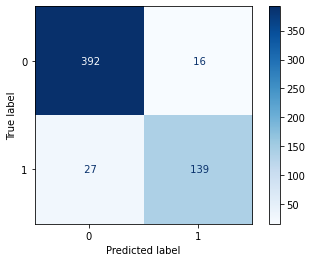

In [ ]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

## Logistic regression

In [ ]:
clf = LogisticRegression(class_weight = 'balanced')

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f64f4c88f10>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f65020563b0>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
             

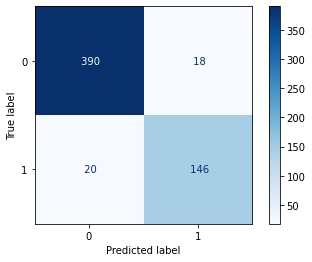

In [ ]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

In [ ]:
y_pred = pipe.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       408
           1       0.89      0.88      0.88       166

    accuracy                           0.93       574
   macro avg       0.92      0.92      0.92       574
weighted avg       0.93      0.93      0.93       574



## XGB 

In [ ]:
clf = XGBClassifier(class_weight = 'balanced')

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f6501e57f90>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...
                               class_weight='balanced', colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100

In [ ]:
predicted = pipe.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, predicted))
print("XGBoost Recall:", recall_score(y_test, predicted))

XGBoost Accuracy: 0.9250871080139372
XGBoost Recall: 0.7891566265060241


In [ ]:
y_pred = pipe.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       408
           1       0.94      0.79      0.86       166

    accuracy                           0.93       574
   macro avg       0.93      0.88      0.90       574
weighted avg       0.93      0.93      0.92       574



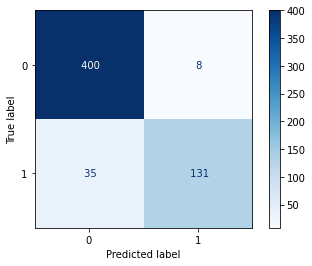

In [ ]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

## Optimizing based on the current recall score using grid search

In [ ]:
# clf = RandomForestClassifier()
clf = LogisticRegression()

# param_grid = {
#     'min_samples_split': [3, 5, 10], 
#     'n_estimators' : [100, 300],
#     'max_depth': [3, 5, 15, 25],
#     'max_features': [3, 5, 10, 20]
# }

param_grid = {
     'penalty' : ['l1', 'l2'],
    # 'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
def grid_search_wrapper(X, y, Xtest, refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)

    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    
    grid_search.fit(X, y)

    # make the predictions
    y_pred = grid_search.predict(Xtest)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search


In [ ]:
predictors.fit(predictors, X=X_train,y=y_train)
X_train_new = predictors.transform(predictors,X=X_train)
X_test_new = predictors.transform(predictors,X=X_test)

In [ ]:
bow_vector.fit(X_train_new, y_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f97a1363048>,
                vocabulary=None)

In [ ]:
# X_train_vector = bow_vector.fit_transform(X_train_new).toarray()
X_train_vector = bow_vector.fit_transform(X_train_new)
X_test_vector = bow_vector.fit_transform(X_test_new)

In [ ]:
grid_search_clf = grid_search_wrapper(X= X_train_vector, y = y_train, Xtest= X_test_vector, refit_score='recall_score')

## Optimizing based on the ROC curve (insp from PSTAT231)

In [ ]:
y_scores = pipe.predict_proba(X_test)[:, 1]


In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9796430774384419


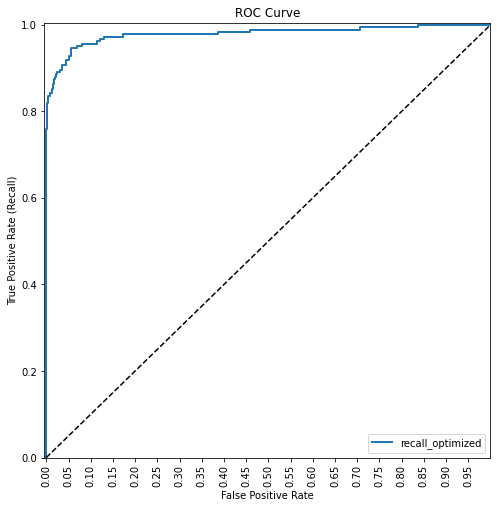

In [ ]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [ ]:
youden = list(tpr - fpr)

youden.index(max(youden)) #the maximum youden value's index is 58

58

In [ ]:
print(auc_thresholds[58], 'is our optimized auc threshold \n', 
      tpr[58], 'is the recall score (TP) at there \n',
      fpr[58], 'is the false positive rate at there') 

0.010285964722972621 is our optimized auc threshold 
 0.9453551912568307 is the recall score (TP) at there 
 0.05511346890657236 is the false positive rate at there


# Approach #2 using RNNS including LSTM, BERT

## Import

In [ ]:
import re
import string
from string import punctuation
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix

from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import word_tokenize, sent_tokenize

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop = ENGLISH_STOP_WORDS.union(stop)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Create embedding matrix

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [ ]:
df.reset_index(inplace=True)

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
voc_size=5000

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [ ]:
len(onehot_repr)

2866

In [ ]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[ 801 2410 4019 ... 2419   79 3308]
 [1091 2442 2426 ...  801 4845 4501]
 [1366 2754  621 ... 2854 1954  103]
 ...
 [3330 2877 2310 ... 1056 3183  499]
 [1492 2806 1492 ... 2352 3428  186]
 [1394 3165 4019 ... 1043 3385 3956]]


In [ ]:
y = df['fraudulent']


In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=32)

## Bidirectional LSTM

In [ ]:
embedding_vector_features=50
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) 
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['AUC'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            250000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 371,001
Trainable params: 371,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64, class_weight= {0:1 , 1:2})

Epoch 1/5
34/34 [==============================] - 2s 19ms/step - loss: 0.0484 - auc: 0.9993 - val_loss: 0.6563 - val_auc: 0.8867
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 0.0375 - auc: 0.9995 - val_loss: 0.5565 - val_auc: 0.9066
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 0.0260 - auc: 0.9989 - val_loss: 0.5850 - val_auc: 0.8904
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 0.0143 - auc: 0.9996 - val_loss: 0.7249 - val_auc: 0.8760
Epoch 5/5
34/34 [==============================] - 1s 16ms/step - loss: 0.0088 - auc: 0.9996 - val_loss: 0.6405 - val_auc: 0.8813


In [ ]:
y_pred=model1.predict_classes(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       476
           1       0.82      0.71      0.76       241

    accuracy                           0.85       717
   macro avg       0.84      0.81      0.82       717
weighted avg       0.85      0.85      0.85       717



## BERT

In [ ]:
# !pip install transformers
# !pip install tensorflow==2.1.0
!pip install simpletransformers
# !pip install tokenizers==0.7.0

In [ ]:
!export CUDA_HOME=/usr/local/cuda-10.1
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --no-cache-dir ./

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
import spacy, re
#Data Cleanup
df = df_balanced

df['text']=df['text'].str.replace('\n','')
df['text']=df['text'].str.replace('\r','')
df['text']=df['text'].str.replace('\t','')
  
#This removes unwanted texts
df['text'] = df['text'].apply(lambda x: re.sub(r'[0-9]','',x))
df['text'] = df['text'].apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.:-]',' ',x))
  
#Converting all upper case to lower case
df['text']= df['text'].apply(lambda s:s.lower() if type(s) == str else s)
  

#Remove un necessary white space
df['text']=df['text'].str.replace('  ',' ')

#Remove Stop words
nlp=spacy.load("en_core_web_sm")
df['text'] =df['text'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False ]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df.fraudulent, test_size = 0.20, stratify=df.fraudulent, random_state=777)

train_df = pd.DataFrame({0: X_train, 1: y_train})
test_df = pd.DataFrame({0: X_test, 1: y_test})

In [ ]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('bert', 'bert-base-uncased', num_labels=2, args={'overwrite_output_dir': True, "train_batch_size": 64, "save_steps": 10000, "save_model_every_epoch":False,
                                                                           'num_train_epochs': 4}, use_cuda=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.train_model(train_df)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2292


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


(144, 0.21347051157823038)

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(test_df)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_574


Running Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8389266658307896, 'tp': 154, 'tn': 381, 'fp': 20, 'fn': 19, 'auroc': 0.9695054271834864, 'auprc': 0.9289564024856051, 'eval_loss': 0.2395165317122721}


In [ ]:
preds = [np.argmax(tuple(m)) for m in model_outputs]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df[1], preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       401
           1       0.89      0.89      0.89       173

    accuracy                           0.93       574
   macro avg       0.92      0.92      0.92       574
weighted avg       0.93      0.93      0.93       574



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df[1], preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.88      0.83      0.86       173

    accuracy                           0.99      3576
   macro avg       0.94      0.91      0.93      3576
weighted avg       0.99      0.99      0.99      3576

